We try generating realistic negative examples by filling gaps in sentences with language models.

It turns out that these harder hegatives do not improve the quality w.r.t. just random word replacement, and they are slower, so we don't insist on this approach. 

In [1]:
import pandas as pd
import numpy as np

import torch
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [2]:
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
import random

In [3]:
from transformers.optimization import Adafactor
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

In [4]:
data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

data.data_split.value_counts()

train    104317
test      35648
dev       34998
val        1743
Name: data_split, dtype: int64

In [5]:
data_train = data[data.data_split=='train']
data_val = data[data.data_split=='val'].copy()
data_train.sample(3)

,date,ba,ru,is_correct,data_split
101471,14/11/2022 17:45:23,Йылдар үтә торҙо.,Шли годы.,1,train
18696,07/10/2021 10:59:32,Малайҙарының араһы алты йәш тирәһе.,Разница в возрасте мальчиков – шесть лет.,1,train
1224,21/09/2021 12:39:40,Аҙна тигәндә миңә лә хаты килеп төштө.,Через неделю и мне пришло письмо от нее.,1,train


In [6]:
base_model = 'bert-base-multilingual-cased'

# Loading the replacers

In [11]:
data_train_correct = data_train[data_train.is_correct == 1]
print(data_train_correct.shape, data_train.shape)

(81268, 5) (104317, 5)


In [12]:
all_pairs = [(row.ba, row.ru) for row in tqdm(data_train_correct.itertuples())]
len(all_pairs)

0it [00:00, ?it/s]

81268

In [7]:
# borrowed from https://github.com/natasha/naeval/tree/master/naeval/segment

import re
from collections import namedtuple


TOKEN = re.compile(r'([^\W\d]+|\d+|[^\w\s])')
WORD = re.compile('^[\w\d]+$')

Substring = namedtuple('Substring', ['start', 'end', 'text'])

def find_substrings(chunks, text):
    offset = 0
    for chunk in chunks:
        start = text.find(chunk, offset)
        stop = start + len(chunk)
        yield Substring(start, stop, chunk)
        offset = stop

def re_tokenize(text):
    chunks = TOKEN.findall(text)
    return find_substrings(chunks, text)

def is_word(text):
    return bool(re.match(WORD, text))

In [8]:
def insert_word(sent, word, position=None):
    """ Cleanly insert a word randomly into a sentence"""
    toks = list(re_tokenize(sent))
    # before which token we'll insert the word
    if position is None:
        position = random.randint(0, len(toks) if is_word(toks[-1].text) else len(toks)-1)
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        return word + ' ' + sent[0].lower() + sent[1:]
    if position == len(toks): # the last token is a word, so we just add one more
        return sent + ' ' + word
    next_tok = toks[position]
    if is_word(next_tok.text) or sent[next_tok.start-1] == ' ':
        word = word + ' '  # insert space between the added word and the next one
    else:
        word = ' ' + word
    return sent[:next_tok.start] + word + sent[next_tok.start:]

def remove_word(sent, position=None):
    """ Cleanly remove a word randomly from a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    
    if position == 0:
        res = sent[toks[1].start:]
        if sent[0].isupper():
            res = res[0].upper() + res[1:]
        return res
    if position == len(toks)-1:
        return sent[:toks[-2].end]
    tok = toks[position]
    spaces_around = (sent[tok.start-1] == ' ') + (sent[tok.end] == ' ')
    extra_space = ''
    if spaces_around == 2 or not is_word(tok.text) and spaces_around == 1:
        extra_space = ' '
    return sent[:toks[position-1].end] + extra_space + sent[toks[position+1].start:]


def replace_word(sent, word, position=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 1:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    tok = toks[position]
    
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        res = word
    else:
        res = sent[:tok.start] + (' ' if sent[tok.start-1] != ' ' and not is_word(tok.text) else '') + word
    if position < len(toks) - 1:
        if sent[tok.end] != ' ' and not is_word(tok.text):
            res = res + ' '
        res = res + sent[tok.end:]
    return res


def swap_words(sent, position1=None, position2=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position1 is None:
        position1 = random.randint(0, len(toks)-1)
    while position2 is None or position2 == position1:
        position2 = random.randint(0, len(toks)-1)
    w1, w2 = toks[position1].text, toks[position2].text
    
    sent = replace_word(sent, w2, position1)
    sent = replace_word(sent, w1, position2)
    return sent


def get_other_word(ix):
    sent = random.choice(all_pairs)[ix]
    return random.choice(list(re_tokenize(sent))).text


def corrupt_sentence(sent, ix, p_edit=0.5):
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent.split()) == 1:
            sent = insert_word(sent, get_other_word(ix))
        # replace a random word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = replace_word(sent, get_other_word(ix))
        # remove a word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = remove_word(sent)
        # swap words
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = swap_words(sent)
    return sent

def corrupt_pair(pair):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])
    sent = pair[ix]
    pair[ix] = corrupt_sentence(sent, ix)
    return pair

In [14]:
pair = random.choice(all_pairs)
pair

('Ниңә мине үлмәҫ борон күмергә йыйынаһың?» – тип ҡысҡырам.',
 'Что ты меня раньше времени заживо хоронишь?!»')

In [27]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

ba_t5_path = '../models/t5-tiny-bak/'
ru_t5_path = '../models/t5-tiny-rus/'

t5_model_ba = AutoModelForSeq2SeqLM.from_pretrained(ba_t5_path)
t5_model_ru = AutoModelForSeq2SeqLM.from_pretrained(ru_t5_path)
t5_tok_ba = AutoTokenizer.from_pretrained(ba_t5_path)
t5_tok_ru = AutoTokenizer.from_pretrained(ru_t5_path)

In [104]:
t5_model_ba.cuda()
t5_model_ru.cuda();

In [28]:
def fill_gap_task(text=None, min_sent_len=3, p_num_words=0.5, left_pad=0, right_pad=0, mask_token='<extra_id_0>'):
    if text is None:
        text = random.choice(all_sents)
    words = text.split()
    if len(words) < min_sent_len:
        return fill_gap_task()
    # to choose between all substrings uniformly, pick both ends uniformly and re-pick if the order is incorrect.
    left_id, right_id = 1, -1
    while left_id > right_id:
        left_id, right_id = [random.randint(left_pad, len(words)-1-right_pad) for _ in range(2)]
    #left_id = random.randint(left_pad, right_id)
    if random.random() > p_num_words:
        filler = [mask_token]
    else:
        filler = [mask_token.replace('0', str(right_id-left_id+1))]
    lhs = ' '.join(words[:left_id] + filler + words[right_id+1:])
    rhs = ' '.join(words[left_id:(right_id+1)])
    return lhs, rhs

In [29]:
set({fill_gap_task('Мама мыла раму') for _ in range(100)})

{('<extra_id_0>', 'Мама мыла раму'),
 ('<extra_id_0> мыла раму', 'Мама'),
 ('<extra_id_0> раму', 'Мама мыла'),
 ('<extra_id_1> мыла раму', 'Мама'),
 ('<extra_id_2> раму', 'Мама мыла'),
 ('<extra_id_3>', 'Мама мыла раму'),
 ('Мама <extra_id_0>', 'мыла раму'),
 ('Мама <extra_id_0> раму', 'мыла'),
 ('Мама <extra_id_1> раму', 'мыла'),
 ('Мама <extra_id_2>', 'мыла раму'),
 ('Мама мыла <extra_id_0>', 'раму'),
 ('Мама мыла <extra_id_1>', 'раму')}

In [142]:
RE_MASK_TOKEN = re.compile('<extra_id_\d+>') 

def rep_texts(texts, model, tokenizer, p_num_words=0.5, max_length=16, do_sample=True, **gen_kwargs):
    if len(texts) == 0:
        return []
    gapped = [fill_gap_task(t, min_sent_len=0, p_num_words=p_num_words)[0] for t in texts]
    with torch.inference_mode():
        x = tokenizer(gapped, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
        gens = model.generate(**x, num_beams=1, do_sample=do_sample, max_length=max_length, **gen_kwargs)
    fixes = [tokenizer.decode(g, skip_special_tokens=True) for g in gens]
    return [RE_MASK_TOKEN.sub(t2, t1) for t1, t2 in zip(gapped, fixes)]


In [ ]:
rep_texts

In [54]:
rep_texts(['Мама мыла раму.'] *5, t5_model_ru, t5_tok_ru)

['И мы послоют мыла раму.',
 'Но вот раму.',
 'Еще один раму.',
 'Даже, мыла раму.',
 'Мама мыла я.']

In [165]:
def get_pairs_contrastive_batch(bs=4, p_difficult=0.2, p_easy=0.2):
    assert bs >= 4
    batch = random.sample(all_pairs, bs // 2) # data_train_correct.sample(bs // 2)
    pp = batch[:] # [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [1 for row in pp]
    r = random.random()
    if r < p_difficult:  #
        for i in range(len(batch)):
            pp.append(corrupt_pair(pp[i]))
            labels.append(0)
    elif r < p_difficult + p_easy:  # just shuffling the examples in the batch
        for i in range(len(batch)):
            pp.append([pp[i][0], pp[i-1][1]])
            labels.append(0)
    else:  # corrupting one of the texts with a replacer
        k = random.randint(0, len(batch)-1) # the number of pair when the ru one will be corrupted
        ru_ = [ru for ba, ru in batch[:k]] + rep_texts([ru for ba, ru in batch[k:]],  t5_model_ru, t5_tok_ru)
        ba_ = rep_texts([ba for ba, ru in batch[:k]], t5_model_ba, t5_tok_ba) + [ba for ba, ru in batch[k:]]
        for ba, ru in zip(ba_, ru_):
            pp.append([ba, ru])
            labels.append(0)
    return [list(t) for t in zip(*pp)], labels

In [167]:
%%time

get_pairs_contrastive_batch(8, 0, 0)

Wall time: 65 ms


([['Дуҫтары менән осрашыуҙан баш тартырға уйлап та бирмәне.',
   'Ҡайҙа инде, әсәһенә ҡунаҡҡа ебәрмәйҙәр.',
   'Һарайға ингәс кенә ул шыбырҙауынан туҡтаны.',
   'Ғөмүмән, уны күҙҙән ыскындырмаҫҡа кәрәк.',
   'Дуҫтары менән осрашыуҙан баш тартырға улар...',
   'Ҡайҙа инде, әсәһенә ҡунаҡҡа ебәрмәйҙәр.',
   'Һарайға ингәс кенә ул шыбырҙауынан туҡтаны.',
   'Ғөмүмән, уны күҙҙән ыскындырмаҫҡа кәрәк.'],
  ['Он вовсе не собирался избегать встречи с друзьями.',
   'Даже к матери в гости не пускают.',
   'Он перестал шептать, только когда вошел во дворец.',
   'И вообще скажу, не следует с него глаз спускать.',
   'Он вовсе не собирался избегать встречи с друзьями.',
   'Сразу пускают.',
   'Он перестал шептать, только когда он был под названием «',
   'И есть, потому глаз спускать.']],
 [1, 1, 1, 1, 0, 0, 0, 0])

In [173]:
%%time
get_pairs_contrastive_batch(4, 1, 0)
get_pairs_contrastive_batch(4, 0, 1)

Wall time: 999 µs


([['— Нимә хаҡында һөйләне?',
   'Тәү күргәстен дә хәйләкәр-хлин икәнлеген аңлағайным да бит...',
   '— Нимә хаҡында һөйләне?',
   'Тәү күргәстен дә хәйләкәр-хлин икәнлеген аңлағайным да бит...'],
  ['— О чем?',
   'Я-то с первого взгляда раскусила эту лицемерку...',
   'Я-то с первого взгляда раскусила эту лицемерку...',
   '— О чем?']],
 [1, 1, 0, 0])

# Training

In [123]:
model = AutoModelForSequenceClassification.from_pretrained(base_model).cuda();
tokenizer = AutoTokenizer.from_pretrained(base_model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [124]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [125]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-4, clip_threshold=1.0
)
cleanup()

In [126]:
losses = []

In [127]:
head_steps = 5_000
batch_size = 8
report_steps = 100
train_max_length = 256

In [128]:
loss_fn = torch.nn.CrossEntropyLoss()

In [129]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=head_steps)

In [174]:
model.train()
tq = trange(len(losses), head_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/3371 [00:00<?, ?it/s]

1700 0.6688362216949463
1800 0.6537380748987198
1900 0.651728841662407
2000 0.6661780244112014
2100 0.6530238926410675
2200 0.6574004545807839
2300 0.6631911790370941
2400 0.658279511332512
2500 0.6591645675897598
2600 0.6547728404402733
2700 0.6598542073369026
2800 0.6564023107290268
2900 0.6491883635520935
3000 0.6610706517100334
3100 0.6470271936058998
3200 0.6595536369085312
3300 0.6456567442417145
3400 0.6714082992076874
3500 0.659868889451027
3600 0.6625405195355415
3700 0.6493277111649514
3800 0.6498014110326767
3900 0.6451588442921639
4000 0.6587416377663612
4100 0.6332972595095634
4200 0.6458058083057403
4300 0.6579748582839966
4400 0.6587812674045562
4500 0.6613747292757034
4600 0.6516409182548523
4700 0.6420967808365822
4800 0.6510783636569977
4900 0.6560842448472977


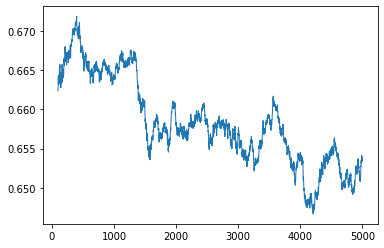

In [175]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [176]:
for p in model.parameters():
    p.requires_grad = True

In [177]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [178]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [179]:
full_steps = 95_000
batch_size = 4
report_steps = 100
train_max_length = 192  # 256 is preferable, but it OOMs often

In [180]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=full_steps)

In [181]:
model.train()
tq = trange(len(losses), head_steps + full_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/95000 [00:00<?, ?it/s]

5000 0.6548877042531968
5100 0.6456122025847435
5200 0.6218376263976098
5300 0.6265651863813401
5400 0.5957427355647087
5500 0.5898661954700947
5600 0.5731288231909275
5700 0.5260448189079762
5800 0.5522290860116482
5900 0.5225563973188401
6000 0.5050463993102312
6100 0.48201564826071264
6200 0.4905979953706264
6300 0.48232581578195094
6400 0.46656240016222
6500 0.46208167806267736
6600 0.44366363652050494
6700 0.4767647493630648
6800 0.46780741982162
6900 0.41917141184210777
7000 0.45139453195035456
7100 0.3926869774609804
7200 0.4169574649631977
7300 0.43234986580908297
7400 0.40230736792087557
7500 0.3790954097360373
7600 0.4210458816587925
7700 0.3910924880951643
7800 0.3590091335773468
7900 0.40902528367936614
8000 0.4358710220083594
8100 0.40323137894272804
8200 0.3969494115933776
8300 0.3937783041968942
8400 0.44183490440249445
8500 0.42899967797100547
8600 0.32437445998191833
8700 0.358428098782897
8800 0.41112129125744107
8900 0.3474420127272606
9000 0.38133668214082717
9100 0

37500 0.2765106471255422
37600 0.3045102099701762
37700 0.3145088669285178
37800 0.24072556972503661
37900 0.25218454603105783
38000 0.30114518892019987
38100 0.30612144388258455
38200 0.2736290089413524
38300 0.2824042635038495
38400 0.30464853536337616
38500 0.29964297607541085
38600 0.3131543793156743
38700 0.24896770101040602
38800 0.2810925293341279
38900 0.2738596496358514
39000 0.28523281536996364
39100 0.2656817827001214
39200 0.3297139959037304
39300 0.30726552214473485
39400 0.31202171836048365
39500 0.3428922560811043
39600 0.33198358919471505
39700 0.34634129725396634
39800 0.30720162972807885
39900 0.3369649101793766
40000 0.3306824589893222
40100 0.2914329842478037
40200 0.3149214607477188
40300 0.30666144352406266
40400 0.342382536418736
40500 0.3078458129614592
40600 0.29535171560943124
40700 0.29416170813143255
40800 0.3315382242947817
40900 0.26890450667589905
41000 0.24934635281562806
41100 0.3108338252082467
41200 0.28416085612028835
41300 0.3094842641800642
41400 0

69800 0.2562864140421152
69900 0.31024896662682294
70000 0.2847030979767442
70100 0.22830857828259468
70200 0.23570340402424336
70300 0.23301591355353593
70400 0.25813765861093996
70500 0.27150663144886494
70600 0.2520217737182975
70700 0.26994419530034064
70800 0.2765660784393549
70900 0.2566643671318889
71000 0.25468968350440263
71100 0.23939376771450044
71200 0.27248950067907574
71300 0.2364716510847211
71400 0.27284444130957125
71500 0.20967245373874902
71600 0.2642546514049172
71700 0.23712520938366652
71800 0.2502310809120536
71900 0.2640683342516422
72000 0.2767932740598917
72100 0.2587011368945241
72200 0.2903919664397836
72300 0.2554572394117713
72400 0.2570073175057769
72500 0.2322935187444091
72600 0.27953152641654017
72700 0.20497960675507784
72800 0.24029942717403174
72900 0.25850804675370453
73000 0.2688241744041443
73100 0.26160712495446203
73200 0.2790427701547742
73300 0.2601378670707345
73400 0.2596552075445652
73500 0.24632049441337586
73600 0.20202482789754866
73700

In [182]:
loss = None
cleanup()
model.eval();

In [183]:
eval_bs = 8

In [184]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

  0%|          | 0/218 [00:00<?, ?it/s]

0.7755463325024963
recall@ ideal reject rate: 0.5452196382428941 th: 0.824577425002231


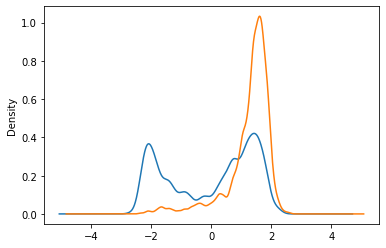

In [185]:
pd.Series(np.log10(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [186]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.8117634
0.8508318990246702


In [187]:
model.save_pretrained('../models/bak-ru-cross-v3-harder-negatives');